# Deep Learning Image Classification

This notebook shows SystemML Deep Learning functionality to map images of single digit numbers to their corresponding numeric representations. See [Getting Started with Deep Learning and Python](http://www.pyimagesearch.com/2014/09/22/getting-started-deep-learning-python/) for an explanation of the used deep learning concepts and assumptions.

The downloaded MNIST dataset contains labeled images of handwritten digits, where each example is a 28x28 pixel image of grayscale values in the range [0,255] stretched out as 784 pixels, and each label is one of 10 possible digits in [0,9]. We download 60,000 training examples, and 10,000 test examples, where the format is "label, pixel_1, pixel_2, ..., pixel_n". We train a SystemML LeNet model. The results of the learning algorithms have an accuracy of 98 percent.

1. [Install and load SystemML and other libraries](#load_systemml)
1. [Download and Access MNIST data](#access_data)
1. [Train a CNN classifier for MNIST handwritten digits](#train)
1. [Detect handwritten Digits](#predict)


<div style="text-align:center" markdown="1">
![Image of Image to Digit](https://www.wolfram.com/mathematica/new-in-10/enhanced-image-processing/HTMLImages.en/handwritten-digits-classification/smallthumb_10.gif)
Mapping images of numbers to numbers
</div>

<a id="load_systemml"></a>
## Install and load SystemML and other libraries

In [26]:
from systemml import MLContext, dml
from pyspark import SparkContext
from systemml import MLContext, dml, dmlFromResource
sc = SparkContext("local", "Simple App")
ml = MLContext(sc)

print "Spark Version:", sc.version
print "SystemML Version:", ml.version()
print "SystemML Built-Time:", ml.buildTime()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=Simple App, master=local) created by __init__ at <ipython-input-1-e3bc3ff5dfb6>:4 

In [ ]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

<a id="access_data"></a>
## Download and Access MNIST data

Download the [MNIST data from the MLData repository](http://mldata.org/repository/data/viewslug/mnist-original/), and then split and save.

In [ ]:
mnist = datasets.fetch_mldata("MNIST Original")

print "Mnist data features:", mnist.data.shape
print "Mnist data label:", mnist.target.shape

trainX, testX, trainY, testY = train_test_split(mnist.data, mnist.target.astype("int0"), test_size = 0.142857)

trainD = np.concatenate((trainY.reshape(trainY.size, 1), trainX),axis=1)
testD  = np.concatenate((testY.reshape (testY.size, 1),  testX),axis=1)

print "Images for training:", trainD.shape
print "Images used for testing:", testD.shape
pix = int(np.sqrt(trainD.shape[1]))
print "Each image is:", pix, "by", pix, "pixels"

np.savetxt('mnist/mnist_train.csv', trainD, fmt='%u', delimiter=",")
np.savetxt('mnist/mnist_test.csv', testD, fmt='%u', delimiter=",")

### Read the data.

In [ ]:
trainData = np.genfromtxt('mnist/mnist_train.csv', delimiter=",")
testData  = np.genfromtxt('mnist/mnist_test.csv', delimiter=",")

print "Training data: ", trainData.shape
print "Test data: ", testData.shape

In [ ]:
pd.set_option('display.max_columns', 200)
pd.DataFrame(testData[1:10,],dtype='uint')

<a id="train"></a>
## Develop LeNet CNN classifier on Training Data

<div style="text-align:center" markdown="1">
![Image of Image to Digit](http://www.ommegaonline.org/admin/journalassistance/picturegallery/896.jpg)
MNIST digit recognition – LeNet architecture
</div>

### (Optional) Display SystemML LeNet Implementation

In [ ]:
!jar -xf ~/.local/lib/python2.7/site-packages/systemml/systemml-java/systemml*.jar scripts/nn/examples/mnist_lenet.dml
!cat scripts/nn/examples/mnist_lenet.dml
#!cat mnist_lenet.dml


### Train Model using SystemML LeNet CNN.

In [ ]:
ml.setStatistics(False)

In [ ]:
# ml.setExplain(True).setExplainLevel('runtime')

In [ ]:
script = """
  source("scripts/nn/examples/mnist_lenet.dml") as mnist_lenet
  # Bind data; Extract images and labels
  n = nrow(data)
  images = data[,2:ncol(data)]
  labels = data[,1]

  # Scale images to [-1,1], and one-hot encode the labels
  images = (images / 255.0) * 2 - 1
  labels = table(seq(1, n), labels+1, n, 10)

  # Split data into training (55,000 examples) and validation (5,000 examples)
  X = images[5001:nrow(images),]
  X_val = images[1:5000,]
  y = labels[5001:nrow(images),]
  y_val = labels[1:5000,]

  # Train the model using channel, height, and width to produce weights/biases.
  [W1, b1, W2, b2, W3, b3, W4, b4] = mnist_lenet::train(X, y, X_val, y_val, C, Hin, Win, epochs)
"""
rets = ('W1', 'b1','W2','b2','W3','b3','W4','b4')

script = (dml(script).input(data=trainData, epochs=1, C=1, Hin=28, Win=28)
                     .output(*rets))   

W1, b1, W2, b2, W3, b3, W4, b4 = ml.execute(script).get(*rets)

Use trained model and predict on test data, and evaluate the quality of the predictions for each digit.

In [ ]:
scriptPredict = """
  source("scripts/nn/examples/mnist_lenet.dml") as mnist_lenet

  # Separate images from lables and scale images to [-1,1]
  X_test = data[,2:ncol(data)]
  X_test = (X_test / 255.0) * 2 - 1

  # Predict
  probs = mnist_lenet::predict(X_test, C, Hin, Win, W1, b1, W2, b2, W3, b3, W4, b4)
  predictions = rowIndexMax(probs) - 1
"""
script = (dml(scriptPredict).input(data=testData, C=1, Hin=28, Win=28, W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3, W4=W4, b4=b4)
                            .output("predictions"))

predictions = ml.execute(script).get("predictions").toNumPy()

print classification_report(testData[:,0], predictions)

<a id="predict"></a>
## Detect handwritten Digits

Define a function that randomly selects a test image, display the image, and scores it.

In [22]:
img_size = np.sqrt(testData.shape[1] - 1).astype("uint8")

def displayImage(i):
    image = testData[i,1:].reshape((img_size, img_size)).astype("uint8")
    imgplot = plt.imshow(image, cmap='gray')   

In [23]:
def predictImage(i):
    image = testData[i,:].reshape(1,testData.shape[1])
    prog = dml(scriptPredict).input(data=image, C=1, Hin=28, Win=28, W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3, W4=W4, b4=b4) \
                             .output("predictions")
    result = ml.execute(prog)
    return (result.get("predictions").toNumPy())[0]

SystemML Statistics:
Total execution time:		0.048 sec.
Number of executed Spark inst:	1.


Image [9468] 
Predicted digit: [ 1.] 
Actual digit:  [ 1.] 
Result:  [ True]


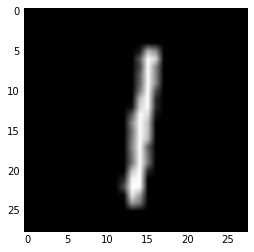

In [28]:
i = np.random.choice(np.arange(0, len(testData)), size = (1,))

p = predictImage(i)

print "Image", i, "\nPredicted digit:", p, "\nActual digit: ", testData[i,0], "\nResult: ", (p == testData[i,0])

displayImage(i)

In [25]:
pd.set_option('display.max_columns', 28)
pd.DataFrame((testData[i,1:]).reshape(img_size, img_size),dtype='uint')

0   1   2   3   4   5   6    7    8    9    10   11   12   13   14   15  \
0    0   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0   
1    0   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0   
2    0   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0   
3    0   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0   
4    0   0   0   0   0   0   0    0    0    7  105  105  211  254  254  139   
5    0   0   0   0   0   0   0    0   50  160  253  253  253  253  253  253   
6    0   0   0   0   0   0   0   78  238  253  253  253  251  238  252  253   
7    0   0   0   0   0   0   0  254  253  253  196  133  118    0  127  154   
8    0   0   0   0   0   0   0  122  253  108   16    0    0    0    0   19   
9    0   0   0   0   0   0   0   93  187   26    0    0    0    0   11  158   
10   0   0   0   0   0   0   0    0    0    0    0    0    0    0   90  253   
11   0   0   0   0   0   0   0    0    0    0    0    0    0   48  236  253   
12   0   0   0   0   0   0   0    0    0    0    0    0   24  226  253  245   
13   0   0   0   0   0   0   0    0    0    0    0   45  162  253  253  208   
14   0   0   0   0   0   0   0    0    0    0    0  226  254  254  217   35   
15   0   0   0   0   0   0   0    0    0    4  131  248  253  253   40    0   
16   0   0   0   0   0   0   0    0    0   24  253  253  251  158    5    0   
17   0   0   0   0   0   0   0    0    0  164  253  253  223    0    0    0   
18   0   0   0   0   0   0   0    0    0  164  253  253  179    0    0    0   
19   0   0   0   0   0   0   0    0    0  164  253  253   74    0    0    6   
20   0   0   0   0   0   0   0    0    0  164  253  253  169  134  134  156   
21   0   0   0   0   0   0   0    0    0  164  253  253  253  253  253  253   
22   0   0   0   0   0   0   0    0    0  135  229  253  253  253  253  253   
23   0   0   0   0   0   0   0    0    0    0   49  147  253  253  253  138   
24   0   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0   
25   0   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0   
26   0   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0   
27   0   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0   

     16   17   18   19   20   21   22   23   24   25  26  27  
0     0    0    0    0    0    0    0    0    0    0   0   0  
1     0    0    0    0    0    0    0    0    0    0   0   0  
2     0    0    0    0    0    0    0    0    0    0   0   0  
3     0    0    0    0    0    0    0    0    0    0   0   0  
4   105   63    0    0    0    0    0    0    0    0   0   0  
5   253  236   72    0    0    0    0    0    0    0   0   0  
6   253  254  232   58    0    0    0    0    0    0   0   0  
7   253  254  253   89    0    0    0    0    0    0   0   0  
8   192  254  253   89    0    0    0    0    0    0   0   0  
9   253  254  210   26    0    0    0    0    0    0   0   0  
10  253  254  114    0    0    0    0    0    0    0   0   0  
11  253  217   29    0    0    0    0    0    0    0   0   0  
12  120   35    0    0    0    0    0    0    0    0   0   0  
13    0    0    0    0    0    0    0    0    0    0   0   0  
14    0    0    0    0    0    0    0    0    0    0   0   0  
15    0    0    0    0    0    0    0    0    0    0   0   0  
16    0    0    0    0    0    0    0    0    0    0   0   0  
17    0    0    0    0    0    0    0    0    0    0   0   0  
18    0    0    0    0    0   23   75   75   75   62   0   0  
19   30   31  119  128  179  201  253  253  253  235  62   0  
20  253  254  253  253  253  253  253  253  205   98   0   0  
21  253  255  253  253  253  173   57   14    9    0   0   0  
22  226  209   85   59   59    7    0    0    0    0   0   0  
23   43    0    0    0    0    0    0    0    0    0   0   0  
24    0    0    0    0    0    0    0    0    0    0   0   0  
25    0    0    0    0    0    0    0    0    0    0   0   0  
26    0    